In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import torch.quantization
from tqdm import tqdm 
from torch.nn.utils import prune
# import hls4ml

In [2]:
def AUC(model,test_loader):
    model.eval()
    y_pre = []
    y_labe = []
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            y_pre=np.append(y_pre,outputs.numpy())
            y_labe=np.append(y_labe,labels.numpy())
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_labe, y_pre)
    print(f'AUC = {auc}')

## The original model

- Memory Calculation:
1. Layer 0:
    - Weights: 140 * 32 parameters
    - Biases: 32 parameters
    - Memory: M0 = (140 * 32 + 32) * 4 = 18048 bytes = 18048/1024 KB = 17.625 KB
2. Layer 1: 
    - Weights: 32 * 16 parameters
    - Biases: 16 parameters
    - Memory: M1 = (32 * 16 + 16) * 4 = 2112 bytes = 2.0625 KB
3. Layer 2:
    - Weights: 16 * 1 parameters
    - Biases: 1 parameters
    - Memory: M2 = (16 * 1 + 1) * 4 = 68 bytes 
Memory Calculation for Parameters:
1. Weights: In each layer is the production of the input and output sizes. For biases, it is the output size of the layer.
2. Total Memory: Sum up all weights and biases across all layers and multiply by 4 bytes (for 32-bit precision).

M = 18048 + 2112 + 68 bytes = 19.754 KB


In [3]:
batch = 1024
num_epochs = 40
layers = [32,16,16]
lr = 0.001
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)


class BinaryClassificationModel(nn.Module):
    def __init__(self):
        super(BinaryClassificationModel, self).__init__()
        self.layer0 = nn.Linear(X.shape[1], layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.layer0(x))
        x = torch.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

model = BinaryClassificationModel()

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


losses = []
stt = time.time()
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
        losses.append(loss)
        # print(f'Epoch {epoch+1}, Estimate:{dtt}, Loss: {loss.item()}')
        t.set_postfix(train_loss=loss.item())


model.eval()
y_pre = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pre.append(predicted)
        
accuracy = correct / total
print(f'Accuracy: {accuracy}')

 57%|█████▊    | 23/40 [01:42<01:15,  4.46s/it, train_loss=0.232]


(array([  69.,   52.,   64.,   62.,   95.,  131.,  256.,  472., 1116.,
        5162.]),
 array([4.03692975e-04, 1.00363324e-01, 2.00322954e-01, 3.00282585e-01,
        4.00242216e-01, 5.00201846e-01, 6.00161477e-01, 7.00121108e-01,
        8.00080739e-01, 9.00040369e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

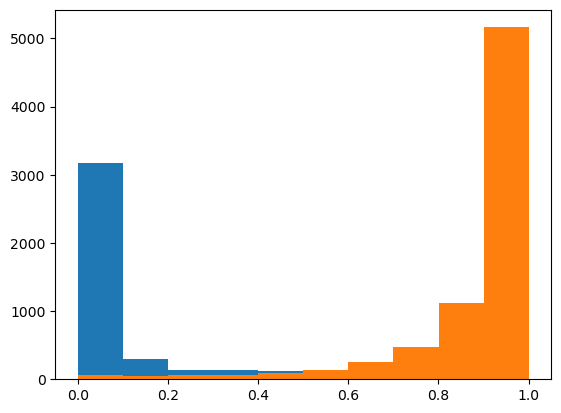

In [22]:
plt.hist(y_pre[y_test==0])
plt.hist(y_pre[y_test==1])

In [14]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.965540333696719


In [ ]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losses)):
    lss.append(losses[i].detach())
plt.plot(lss)

## Quantized


In [22]:
batch = 1024
num_epochs = 40
layers = [32,16,16]
lr = 0.001
df = pd.read_parquet('df.parquet')
X = pd.read_parquet('x.parquet').values  
df['proc'] = df['proc'].apply(lambda x: 1 if x != 0 else 0)
y = df['proc'].values  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch, shuffle=False)

class BitMask(nn.Module):
    def __init__(self, size, mask=None):
        super(BitMask, self).__init__()
        if mask is None:
            self.mask = torch.ones(size, dtype=torch.float32)
        else:
            assert mask.size() == size
            self.mask = mask

    def forward(self, x):
        return x * self.mask
    



class BinaryClassificationModelQ(nn.Module):
    def __init__(self, num_features, mask_size=None, mask=None):
        super(BinaryClassificationModelQ, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.layer0 = nn.Linear(num_features, layers[0])
        self.layer1 = nn.Linear(layers[0], layers[1])
        self.bitmask = BitMask(mask_size or layers[1], mask)
        self.layer2 = nn.Linear(layers[1], 1)
        self.sigmoid = nn.Sigmoid()
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = torch.relu(self.layer0(x))
        x = self.layer1(x)
        x = self.bitmask(x)
        x = torch.relu(x)
        x = self.sigmoid(self.layer2(x))
        x = self.dequant(x)
        return x
modelQ = BinaryClassificationModelQ(X.shape[1])

modelQ.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(modelQ, inplace=True)


def Quantrain(model):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    losses = []
    stt = time.time()
    # for layer, name in parameters_to_prune:
    #     prune.l1_unstructured(layer, name=name, amount=pruning_amount)
    with tqdm(range(num_epochs)) as t:
        for epoch in t:
            for inputs, labels in train_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            losses.append(loss)
            t.set_postfix(train_loss=loss.item())
            
    
    return losses, model

def Acc(model):
    model.eval()
    model = torch.quantization.convert(model, inplace=True)
    y_pre = []

    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pre.append(predicted)
            
    accuracy = correct / total
    return accuracy

/vols/cms/hw423/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [23]:
losess, modelQ = Quantrain(modelQ)

100%|██████████| 40/40 [03:42<00:00,  5.57s/it, train_loss=0.327]


In [25]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = modelQ(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.9261048830997973


In [7]:
y_pre = []
y_labe = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = modelQ(inputs)
        y_pre=np.append(y_pre,outputs.numpy())
        y_labe=np.append(y_labe,labels.numpy())
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_labe, y_pre)
print(f'AUC = {auc}')

AUC = 0.8322178750209352


(array([  11.,   69.,  178.,  266.,  725.,  837.,  958.,  810.,  918.,
        2707.]),
 array([0.06640625, 0.159375  , 0.25234375, 0.3453125 , 0.43828125,
        0.53125   , 0.62421875, 0.7171875 , 0.81015625, 0.903125  ,
        0.99609375]),
 <BarContainer object of 10 artists>)

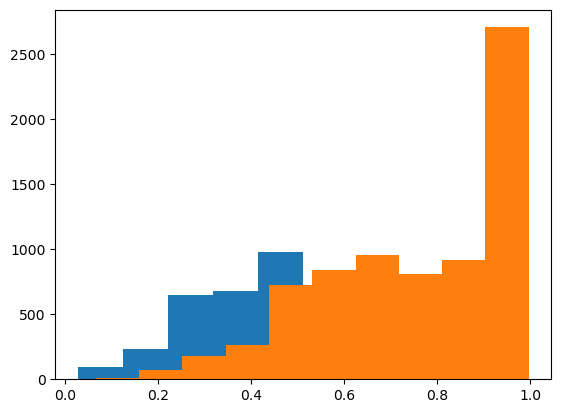

In [8]:
plt.hist(y_pre[y_test==0])
plt.hist(y_pre[y_test==1])

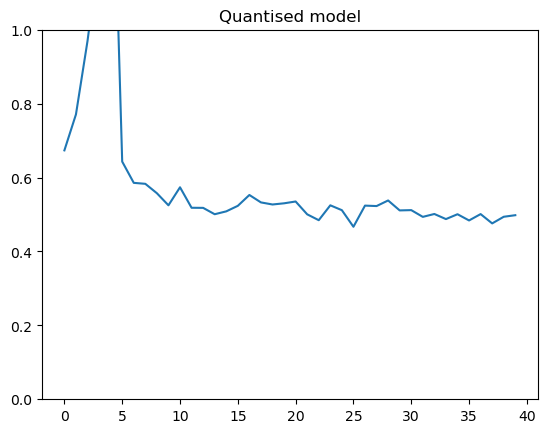

In [18]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losess)):
    lss.append(losess[i].detach())
plt.title('Quantised model')
plt.ylim(0,1)
plt.plot(lss)

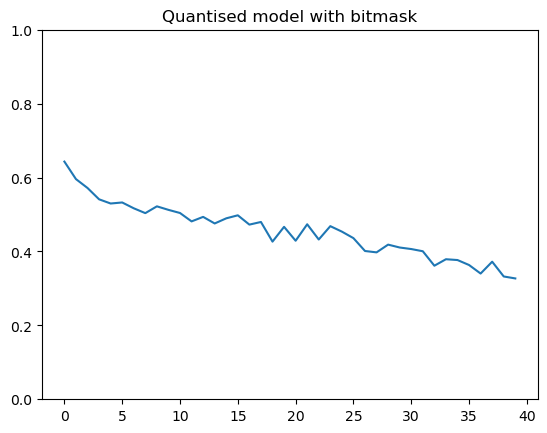

In [24]:
import matplotlib.pyplot as plt
lss = []
for i in range(len(losess)):
    lss.append(losess[i].detach())
plt.title('Quantised model with bitmask')
plt.ylim(0,1)
plt.plot(lss)

(array([  10.,   23.,   47.,  209.,  345.,  750.,  911.,  859., 1071.,
        3254.]),
 array([0.01171875, 0.11015625, 0.20859375, 0.30703125, 0.40546875,
        0.50390625, 0.60234375, 0.70078125, 0.79921875, 0.89765625,
        0.99609375]),
 <BarContainer object of 10 artists>)

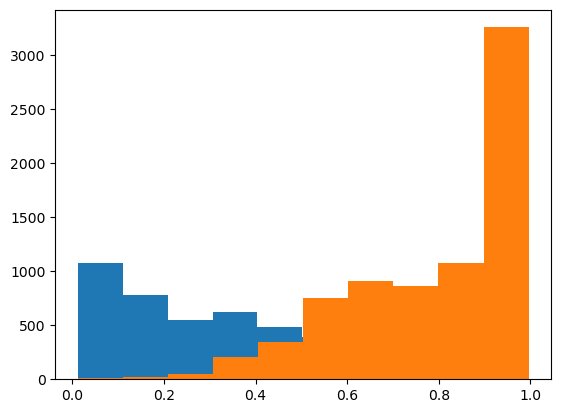

In [26]:
plt.hist(y_pre[y_test==0])
plt.hist(y_pre[y_test==1])

In [26]:
AUC(modelQ,test_loader)

AUC = 0.9175262363312993


In [48]:
print(modelQ)

BinaryClassificationModelQ(
  (quant): Quantize(scale=tensor([0.3081]), zero_point=tensor([27]), dtype=torch.quint8)
  (layer0): QuantizedLinear(in_features=140, out_features=32, scale=0.18849492073059082, zero_point=60, qscheme=torch.per_channel_affine)
  (layer1): QuantizedLinear(in_features=32, out_features=16, scale=0.12984374165534973, zero_point=49, qscheme=torch.per_channel_affine)
  (layer2): QuantizedLinear(in_features=16, out_features=1, scale=0.1536165326833725, zero_point=28, qscheme=torch.per_channel_affine)
  (sigmoid): Sigmoid()
  (dequant): DeQuantize()
)


In [59]:
import os
def model_size(model, label=' '):
    torch.save(model.state_dict(),"/vols/cms/hw423/Acc/mymodel.p")
    size = os.path.getsize("/vols/cms/hw423/Acc/mymodel.p")
    print("model:",label,'\t','Size(KB):',size/1e3)
    os.remove("/vols/cms/hw423/Acc/mymodel.p")
    return size
# compare the size
f = model_size(model, "fp32")
q= model_size(modelQ, "int8")
print("{0:.2f} times smaller".format(f/q))

model: fp32 	 Size(KB): 22.167
model: int8 	 Size(KB): 11.881
1.87 times smaller


In [68]:
model = BinaryClassificationModelQ(X.shape[1])
model.train()

model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model, inplace=True)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
losses = []
stt = time.time()
# for layer, name in parameters_to_prune:
#     prune.l1_unstructured(layer, name=name, amount=pruning_amount)
with tqdm(range(num_epochs)) as t:
    for epoch in t:
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        losses.append(loss)
        t.set_postfix(train_loss=loss.item())
        

        # est = time.time()
        # print(f'Epoch {epoch+1}, Estimate:{(est-stt)/(epoch+1)*(num_epochs-epoch-1)}, Loss: {loss.item()}')
    parameters_to_prune = (
        (model.layer0, 'weight'),
        (model.layer1, 'weight'),
        (model.layer2, 'weight'),
    )
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=0.2,
    )
# model.eval()
# for layer, name in parameters_to_prune:
#     prune.remove(layer, name)
model.eval()
model = torch.quantization.convert(model, inplace=True)
y_pre = []

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pre.append(predicted)
        
accuracy = correct / total
print(f'Accuracy: {accuracy}')

/vols/cms/hw423/env/envs/env/lib/python3.11/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


100%|██████████| 40/40 [04:15<00:00,  6.38s/it, train_loss=0.434]


AttributeError: 'Linear' object has no attribute 'weight_mask'

In [72]:
if hasattr(model.layer2, 'weight_mask'):
    print("剪枝成功应用于layer_name")
else:
    print("剪枝未应用于layer_name")

剪枝未应用于layer_name
